---
title: Symbolic Kinematics with Pynamics
---


In [1]:
%matplotlib inline

In [2]:
# -*- coding: utf-8 -*-
"""
Written by Daniel M. Aukes
Email: danaukes<at>gmail.com
Please see LICENSE for full license.
"""

import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
from pynamics.body import Body
from pynamics.dyadic import Dyadic
from pynamics.output import Output,PointsOutput
from pynamics.particle import Particle
import pynamics.integration
import numpy
import numpy.linalg
import matplotlib.pyplot as plt
from math import pi
import sympy

In [3]:
system = System()
pynamics.set_system(__name__,system)

Define Constants

In [4]:
lA = Constant(1,'lA',system)
lB = Constant(.2,'lB',system)

define time-differentiable state variables

In [5]:
qA,qA_d,qA_dd = Differentiable('qA',system)
qB,qB_d,qB_dd = Differentiable('qB',system)

create frames

In [6]:
N = Frame('N',system)
A = Frame('A',system)
B = Frame('B',system)

Rotate Frames relative to a parent frame

In [7]:
system.set_newtonian(N)
A.rotate_fixed_axis(N,[0,0,1],qA,system)
B.rotate_fixed_axis(A,[0,0,1],qB,system)

Define the kinematics of the system by creating vectors of important points

In [8]:
pNA=0*N.x
pAB=pNA+lA*A.x
pBtip = pAB + lB*B.x

Take the time derivative of the tip

In [9]:
vBtip = pBtip.time_derivative()
vBtip

lA*qA_d*A.y + lB*B.y*(qA_d + qB_d)

Assemble the output velocity vector

In [10]:
dy = sympy.Matrix([vBtip.dot(N.x),vBtip.dot(N.y)])

define the input vector

In [11]:
dq = sympy.Matrix([qA_d,qB_d])

Compute the Jacobian

In [12]:
J = dy.jacobian(dq)
J

Matrix([
[-lA*sin(qA) - lB*sin(qA)*cos(qB) - lB*sin(qB)*cos(qA), -lB*sin(qA)*cos(qB) - lB*sin(qB)*cos(qA)],
[ lA*cos(qA) - lB*sin(qA)*sin(qB) + lB*cos(qA)*cos(qB), -lB*sin(qA)*sin(qB) + lB*cos(qA)*cos(qB)]])

Define an arbitrary configuration

In [13]:
q_num = {qA:30*pi/180,qB:15*pi/180}

Calculate the jacobian at that point

In [14]:
J_num = J.subs(system.constant_values)
J_num = J_num.subs(q_num)
J_num = numpy.array(J_num.evalf(),dtype = float)
J_num

array([[-0.64142136, -0.14142136],
       [ 1.00744676,  0.14142136]])

define the input velocity

In [15]:
dq_num = numpy.array([[.1,.1]]).T

Compute the output velocity

In [16]:
dy_num = J_num.dot(dq_num)
dy_num

array([[-0.07828427],
       [ 0.11488681]])

Plot the system.  
First create a list of points

In [17]:
points = [pNA,pAB,pBtip]

define the basis vectors to dot with

In [18]:
express_in = [N.x,N.y]

Dot each point by each basis vector and assemble into a matrix

In [19]:
points = [[item.dot(bv) for bv in express_in] for item in points]
points = sympy.Matrix(points)

Convert the symbolic expression for points into a set of numerical values and convert to a numpy array

In [20]:
points = points.subs(system.constant_values)
points_num = points.subs(q_num)
points_num = numpy.array(points_num,dtype=float)
points_num

array([[0.        , 0.        ],
       [0.8660254 , 0.5       ],
       [1.00744676, 0.64142136]])

Using matplotlib, plot the arm with the .plot() method and the velocity with the .quiver() method

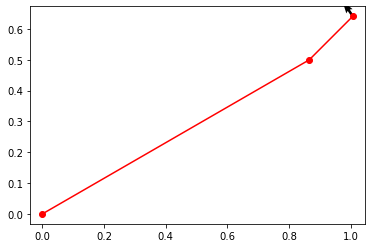

In [21]:
plt.figure()
plt.plot(points_num[:,0],points_num[:,1],'r-o')
plt.quiver(points_num[-1,0],points_num[-1,1],dy_num[0],dy_num[1])
plt.axis('equal')
plt.show()

In [22]:
dy_desired = numpy.array([[0,1]]).T
dq_desired = numpy.linalg.inv(J_num).dot(dy_desired)
dq_desired

array([[  2.73205081],
       [-12.39130907]])

In [23]:
dy = J_num.dot(dq_desired)
dy

array([[-2.22044605e-16],
       [ 1.00000000e+00]])

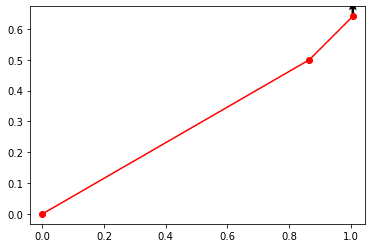

In [24]:
plt.figure()
plt.plot(points_num[:,0],points_num[:,1],'r-o')
plt.quiver(points_num[-1,0],points_num[-1,1],dy[0],dy[1])
plt.axis('equal')
plt.show()

In [25]:
F_end_effector = numpy.array([[-.5,.5]]).T
T = J_num.T.dot(F_end_effector)
T

array([[0.82443406],
       [0.14142136]])

In [26]:
P_end_effector = F_end_effector.T.dot(dy)
P_end_effector

array([[0.5]])

In [27]:
P_actuator = T.T.dot(dq_desired)
P_actuator

array([[0.5]])

In [28]:
q_traj = numpy.c_[numpy.r_[0:60:10j],numpy.r_[15:30:10j]]
q_traj *= pi/180
q_traj

array([[0.        , 0.26179939],
       [0.11635528, 0.29088821],
       [0.23271057, 0.31997703],
       [0.34906585, 0.34906585],
       [0.46542113, 0.37815467],
       [0.58177642, 0.40724349],
       [0.6981317 , 0.43633231],
       [0.81448698, 0.46542113],
       [0.93084227, 0.49450995],
       [1.04719755, 0.52359878]])

In [29]:
import scipy.interpolate
t = numpy.r_[0:10]
f = scipy.interpolate.interp1d(t,q_traj.T,kind='cubic',fill_value='extrapolate')
t2=numpy.r_[0:10:7j]

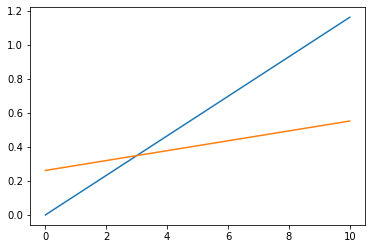

In [30]:
plt.figure()
plt.plot(t2,f(t2).T)

In [31]:
dq_dt = (f(t2[2:]) - f(t2[:-2]))/(t2[2]-t2[0])
dq_dt = dq_dt.T
t2 = t2[1:-1]

[-0.03647627  0.1396432 ]
[-0.06376142  0.12906388]
[-0.08824163  0.11319799]
[-0.10890372  0.09275295]
[-0.12490748  0.06862746]


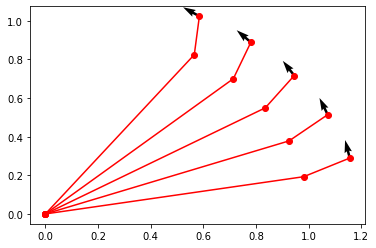

In [32]:
plt.figure()
dy_dt = []
J_num = []
for item,dq_ii in zip(t2,dq_dt):
    subs_ii = dict([(item1,item2) for item1,item2 in zip([qA,qB],f(item))])
    points_num = points.subs(subs_ii)
    points_num = numpy.array(points_num,dtype = float)
    J_num_ii = J.subs(system.constant_values)
    J_num_ii = J_num_ii.subs(subs_ii)
    J_num_ii = numpy.array(J_num_ii,dtype = float)
    J_num.append(J_num_ii)
    dy_ii = J_num_ii.dot(dq_ii)
    dy_dt.append(dy_ii)
    print(dy_ii)
    plt.plot(points_num[:,0],points_num[:,1],'r-o')
    #plt.quiver(points_num[0,0]+.05,points_num[0,1],0,dq_ii[0])
    #plt.quiver(points_num[1,0]+.05,points_num[1,1],0,dq_ii[1])
    plt.quiver(points_num[-1,0],points_num[-1,1],dy_ii[0],dy_ii[1])
dy_dt = numpy.array(dy_dt).T
J_num = numpy.array(J_num)

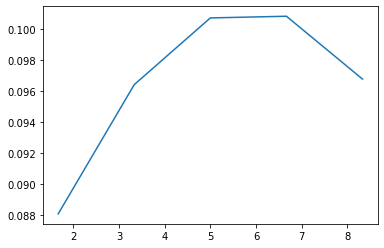

In [33]:
P = F_end_effector.T.dot(dy_dt)
P
plt.plot(t2,P.T)

array([[0.72285087, 0.79327691, 0.83099807, 0.83465928, 0.80435231],
       [0.13586708, 0.141315  , 0.13849968, 0.12758574, 0.10921137]])

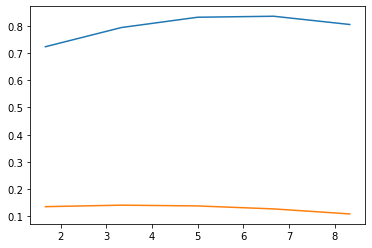

In [34]:
torque = J_num.transpose(0,2,1).dot(F_end_effector)
torque = torque.T.squeeze()
plt.plot(t2,torque.T)
torque

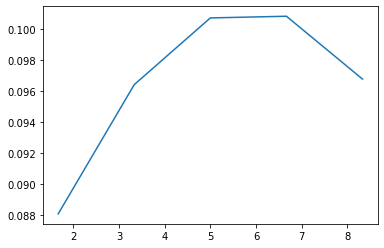

In [35]:
P2 = torque.T*dq_dt
P2 = P2.sum(1)
plt.plot(t2,P2.T)